***

### SOLUTION :


### **Importing Necessary Libraries**

In [20]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
from sklearn import metrics
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import missingno as msno 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm



### **Defining Functions for Data Cleaning and Visualization**



In [21]:
def fill_na_by_median(data, column_name):
    """
    Fills missing values in the specified column of the input data frame using the median value of that column.

    Args:
        data (pandas.DataFrame): The input data frame.
        column_name (str): The name of the column to fill.

    Returns:
        pandas.DataFrame: The input data frame with missing values in the specified column filled by the median value of that column.
    """
    median_value = data[column_name].median()
    data[column_name] = data[column_name].fillna(median_value)
    return data

def data_visualization(data, fig_name):
    """
    Creates a matrix plot and a bar plot to visualize missing values in the input data frame.

    Args:
        data (pandas.DataFrame): The input data frame.
        fig_name (str): The name of the figure.

    Returns:
        None.
    """
    # Create subplots for matrix plot and bar plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Plot matrix plot
    msno.matrix(data, ax=axs[0])

    # Plot bar plot
    msno.bar(data, ax=axs[1])



    

    # Plot pie chart to understand whether data is balanced or not
    labels = ['False', 'True']
    values = [sum(data['isVirus'] == False), sum(data['isVirus'] == True)]
    axs[2].pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    axs[2].axis('equal')

    # Adjust spacing between subplots and add title to the figure
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(fig_name)




def data_visualization_5d(data):
    """
    Creates a 3D scatter plot to visualize data in five dimensions (three features, marker color, and marker size).

    Args:
        data (pandas.DataFrame): The input data frame.

    Returns:
        None.
    """
    # Set marker properties
    marker_color = data['isVirus']
    marker_size = abs(data['feature_4'] * 4)

    # Create Plotly scatter plot
    scatter_plot = go.Scatter3d(x=data['feature_1'],
                                y=data['feature_2'],
                                z=data['feature_3'],
                                marker=dict(size=marker_size,
                                            color=marker_color,
                                            opacity=0.9,
                                            reversescale=True,
                                            colorscale='magenta_r'),
                                line=dict(width=0.02),
                                mode='markers')

    # Create Plotly layout
    plot_layout = go.Layout(title='Visualizing Cleaned Data. Pink Data Means no Virus. Purple Data Means It is Virus. Thickness of Data Corresponds to Feature_4',
                            scene=dict(xaxis=dict(title="feature_1"),
                                       yaxis=dict(title="feature_2"),
                                       zaxis=dict(title="feature_3")))

    # Plot and save html
    plotly.offline.plot({"data": [scatter_plot], "layout": plot_layout}, auto_open=True)




def dimension_reduce(X_res, y_res, dimension):
    """
    Reduces the dimensions of the input features using PCA and returns a DataFrame
    with three principal components and the target variable.

    Parameters:
        X_res (DataFrame): The input features DataFrame.
        y_res (Series): The target variable Series.
        dimension (int): The number of dimensions to reduce the features to.

    Returns:
        data (DataFrame): The reduced dimension DataFrame with the target variable.
    """
    pca = PCA(n_components=dimension)
    X_res = pca.fit_transform(pd.DataFrame(X_res))

    data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
    data.columns = list(X.columns[:dimension]) + ['isVirus']

    return data



def scaler(data):
    """
    Scales the numerical features of the input dataframe using L2 normalization and concatenates the 'isVirus' column.
    
    Args:
        data (pandas DataFrame): The input dataframe to be scaled. Must have numerical columns and an 'isVirus' column.
        
    Returns:
        pandas DataFrame: The scaled dataframe with the 'isVirus' column concatenated.
    """
    # Normalize the numerical features
    scaled_numpyarray = preprocessing.normalize(data.drop('isVirus', axis=1))

    # Convert the scaled numpy array back into a pandas DataFrame
    scaled_dataframe = pd.DataFrame(scaled_numpyarray, columns=list(X.columns))

    # Concatenate the 'isVirus' column back onto the scaled DataFrame
    data = pd.concat([scaled_dataframe, data['isVirus']], axis=1)

    return data

### **Defining Functions Evaluate the Models**

In [22]:
def run_experiment(y_test, y_pred, clf, x_test, model_name):
    """
    Runs a classification experiment and prints the results.

    Args:
        y_test (numpy.ndarray): The true labels.
        y_pred (numpy.ndarray): The predicted labels.
        clf (sklearn classifier): The trained classifier.
        x_test (numpy.ndarray): The test features.
        model_name (str): The name of the model.

    Returns:
        None.
    """
    print("------------------------------------------------------------------------")
    print(f"Results for {model_name}")
    
    # Print evaluation metrics
    print('Confusion Matrix: ', metrics.confusion_matrix(y_test, y_pred))
    print("R^2 Score: ", metrics.r2_score(y_test, y_pred))
    print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
    print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
    print('Recall: %.3f' % metrics.recall_score(y_test, y_pred))
    print('F1: %.3f' % metrics.f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))

    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusion_matrix(y_test, y_pred),
        display_labels=clf.classes_
    )
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Calculate and plot ROC curve
    y_pred_prob = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()




def choosebestmodel(x_train, y_train, x_test, y_test):
    """
    This function uses the AutoSklearnClassifier to automatically choose the best model
    for classification tasks based on the provided training and testing data.

    Parameters:
    x_train (numpy.ndarray): Training data features.
    y_train (numpy.ndarray): Training data labels.
    x_test (numpy.ndarray): Testing data features.
    y_test (numpy.ndarray): Testing data labels.

    Returns:
    None
    """
    import autosklearn.classification
    # Create an instance of AutoSklearnClassifier with a time limit of 120 seconds for model selection
    cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120)

    # Fit the classifier to the training data
    cls.fit(x_train, y_train)

    # Print a detailed leaderboard of the model performances
    print(cls.leaderboard(detailed=True))

    # Make predictions on the testing data
    y_pred = cls.predict(x_test)

    # Print the accuracy score of the model on the testing data
    print("Accuracy score:", metrics.accuracy_score(y_test, y_pred))

### **Cleaning, Visualization, Training Data and Evaluating Models**   






Upload csv file to dataframe to process

In [50]:
data = pd.read_csv('dataset.csv')

Visualize data before clean to see difference. It shows missing values, count of each column without missing data and balance of data

/usr/local/lib/python3.9/dist-packages/missingno/missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



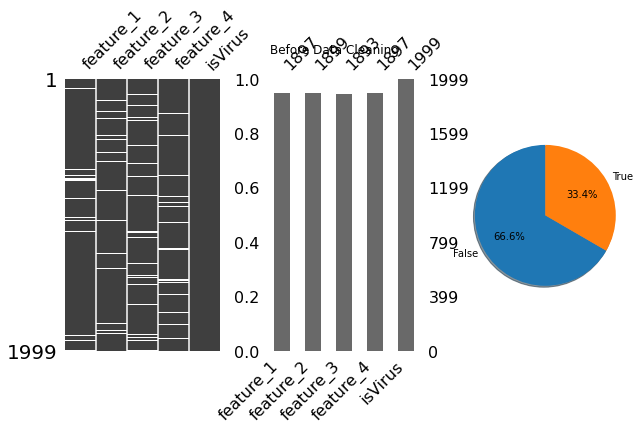

In [51]:
data_visualization(data,'Before Data Cleaning')

**Start Data Cleaning**



Fiil empty values with median values

In [52]:
data=fill_na_by_median(data,'feature_1')
data=fill_na_by_median(data,'feature_2')
data=fill_na_by_median(data,'feature_3')
data=fill_na_by_median(data,'feature_4')


To plot 3d data and make PCA, we change 'isVirus column from true and false to 0 and 1

In [53]:
data["isVirus"] = data["isVirus"].astype(int)


Since our data is imbalanced (%33.4->True, %66.6->Flase) produce senthetic data to handle imbalance data by using SMOTE method

In [54]:
y = data['isVirus']
X = data.drop('isVirus', axis=1)

sm = SMOTE(random_state=0)
X_res, y_res= sm.fit_resample(X, y)
data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
data.columns = list(X.columns) + ['isVirus']


After cleaning data we visualize it both 2d and 3d

/usr/local/lib/python3.9/dist-packages/missingno/missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



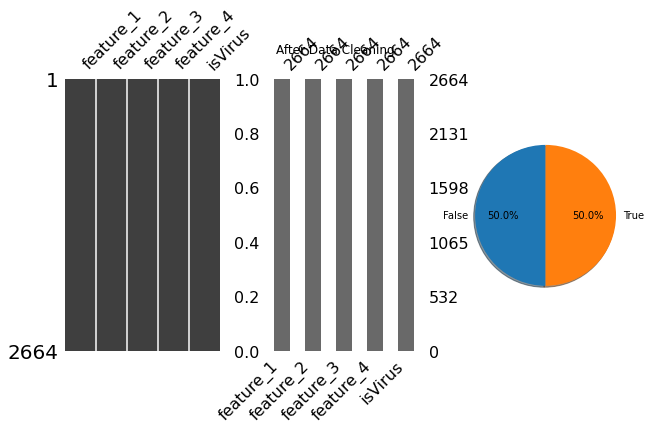

In [55]:
data_visualization(data,'After Data Cleaning')
data_visualization_5d(data)


Note: While trying, scaling and dimension reduce techniques are tried. Since they decreased the accuracy, they did not taken into account.
However if you want to try just run the cell.

In [49]:
data=scaler(data)
data=dimension_reduce(X_res,y_res,2)

Splitting data to train and test (%80 train, %20 test)

In [56]:
x_train, x_test,y_train,y_test = train_test_split(data.iloc[:,:-1].values,data.iloc[:,-1].values,test_size=0.20, random_state=0)

To choose best machine learning algorithm and parameters to fit model Grid Search and cross validation.
However I used autosklearn library to find best algorithm. After that I tried best ones and compared them respect to different metrics.
Autosklearn library is supported on windows OS. If you want to try it on windows machine you can use virtual machine or cloud (Google Colab).
When I try it, I got random forest algorithm is best.

In [12]:
choosebestmodel(x_train,y_train,x_test,y_test)

ModuleNotFoundError: ignored

Train Extra Trees algorithm and see the result respect to different metrics

------------------------------------------------------------------------
Results for Extra Trees
Confusion Matrix:  [[228  38]
 [ 10 257]]
R^2 Score:  0.6397735912815747
MAE:  0.0900562851782364
RMSE:  0.30009379396821323
Precision: 0.871
Recall: 0.963
F1: 0.915
Accuracy: 0.910


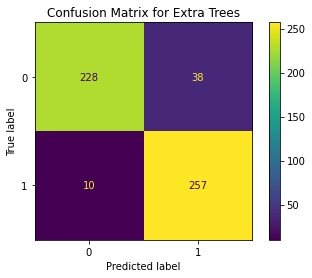

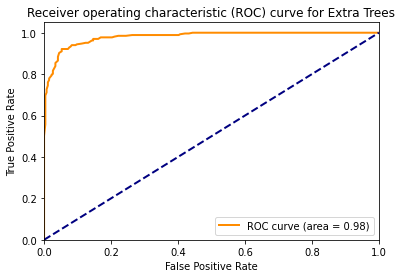

In [57]:
model_extratrees = ExtraTreesClassifier(n_estimators=100, random_state=0)
model_extratrees.fit(x_train, y_train)
y_pred=model_extratrees.predict(x_test)
run_experiment(y_test,y_pred,model_extratrees,x_test,'Extra Trees')

Train Random Forest algorithm and see the result respect to different metrics

------------------------------------------------------------------------
Results for Random Forest Classifier
Confusion Matrix:  [[195  71]
 [ 37 230]]
R^2 Score:  0.18949058038354327
MAE:  0.2026266416510319
RMSE:  0.4501406909523198
Precision: 0.764
Recall: 0.861
F1: 0.810
Accuracy: 0.797


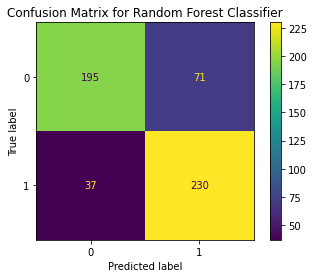

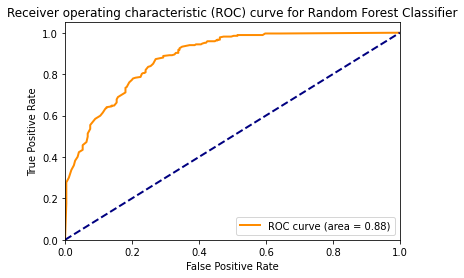

In [32]:
model_randomforestclassifier = RandomForestClassifier()
model_randomforestclassifier.fit(x_train,y_train)
y_pred=model_randomforestclassifier.predict(x_test)
run_experiment(y_test, y_pred,model_randomforestclassifier,x_test,'Random Forest Classifier')

Train SVM algorithm and see the result respect to different metrics

------------------------------------------------------------------------
Results for Support Vector Machines
Confusion Matrix:  [[122 144]
 [ 10 257]]
R^2 Score:  -0.15572639463828097
MAE:  0.28893058161350843
RMSE:  0.5375226335825389
Precision: 0.641
Recall: 0.963
F1: 0.769
Accuracy: 0.711


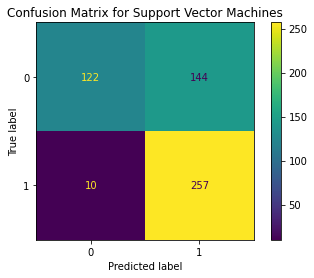

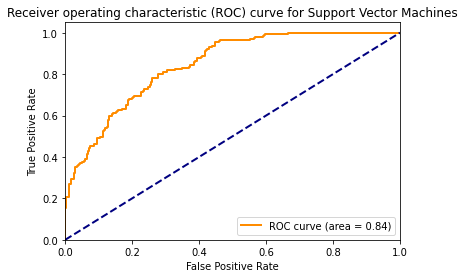

In [33]:
model_svm = svm.SVC(probability=True)
model_svm.fit(x_train,y_train)
y_pred=model_svm.predict(x_test)
run_experiment(y_test, y_pred,model_svm,x_test, 'Support Vector Machines')

Train XGB algorithm and see the result respect to different metrics

------------------------------------------------------------------------
Results for XGB
Confusion Matrix:  [[189  77]
 [ 36 231]]
R^2 Score:  0.15196699614204057
MAE:  0.21200750469043153
RMSE:  0.4604427268297671
Precision: 0.750
Recall: 0.865
F1: 0.803
Accuracy: 0.788


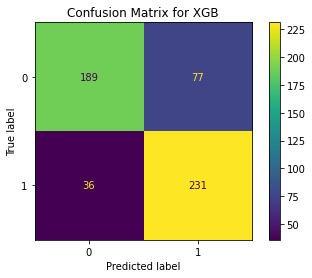

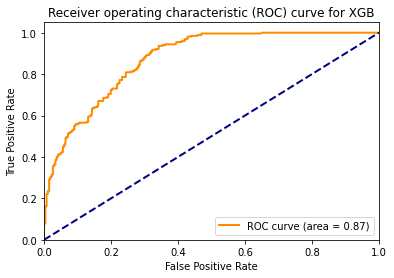

In [34]:
model_xgb=XGBClassifier()
model_xgb.fit(x_train,y_train)
y_pred=model_xgb.predict(x_test)
run_experiment(y_test, y_pred,model_xgb,x_test,'XGB')

Try different algorithm and compare the result respect to different metrics.
Since our data was imbalanced deciding best algorithm looking by accuracy value would be wrong.
So instead, I consider ROC Curve's area. Actually results are quite similar except SVM. 
However, best ROC Curve are belongs to extra trees algorithm which 0.98 I would prefer to use it.
I comment other models trial, If you want to see you can comment out and see the results.


Since none of result is not best other techniques can be used (Deep Neural Networks and its applications).
Also while trying other algorithms some data preperation methods can be applied like normalazing data and reducing dimensions.
